<a href="https://colab.research.google.com/github/nf1973/desert-classifier-learning/blob/main/desert_classifier_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desert Classifer - Learner


## Environmental Prepararation

In [2]:
!pip install -Uqq fastai duckduckgo_search ipywidgets

from duckduckgo_search import ddg_images
from fastai import *
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
from time import sleep

path = Path('./data')

## Specify Categories and Number of Images per Category to be Trained

In [3]:
searches = 'scones','muffins','cheesecake','nussecke','apple_pie'
max_images=100
finetuning_cycles=8

#put the categories in alphabetical order so the images get trained using the correct category
searches = sorted(searches)

## Search and Download Images for each Category

We will now search (DuckDuckGo search) for images for each of the categories that shall be trained, and download the image files into the data folder

In [4]:
def search_images(term, max_images):
    print(f"Searching for '{term}' and downloading {max_images} images")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

# Remove any previously downloaded images
!rm -r ./data/

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

    # Remove any images that failed to download sucessfully
    failed = verify_images(get_image_files(path/o))
    failed.map(Path.unlink)
    print(f"{len(failed)} bad image(s) removed from {o} folder")

    # Convert images to RGB format (just in case some are not)
   # for img_file in dest.ls():
   #     if os.path.isfile(img_file):
   #         img_pil = Image.open(img_file)
   #         img_rgb = img_pil.convert('RGB')
   #         img_rgb.save(img_file)



rm: cannot remove './data/': No such file or directory
Searching for 'apple_pie photo' and downloading 100 images


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


2 bad image(s) removed from apple_pie folder
Searching for 'cheesecake photo' and downloading 100 images
1 bad image(s) removed from cheesecake folder
Searching for 'muffins photo' and downloading 100 images
1 bad image(s) removed from muffins folder
Searching for 'nussecke photo' and downloading 100 images


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 bad image(s) removed from nussecke folder
Searching for 'scones photo' and downloading 100 images
1 bad image(s) removed from scones folder


 ## Set up DataLoaders for the Training
   
 Set up DataLoaders object which will contain a training set (80%) and validation set(20%) made up of the downloaded images. Images will be randomly resized and cropped to give more variations in the data set

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(128, min_scale=0.3)],batch_tfms=aug_transforms(mult=2)
).dataloaders(path, bs=32)


## Finetuning the Model
Use the downloaded and categorized images to finetine the model

In [6]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(finetuning_cycles)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.849561,0.644975,0.263158,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.824814,0.319676,0.105263,01:16
1,0.689717,0.217393,0.078947,01:16
2,0.576535,0.365468,0.092105,01:11
3,0.549215,0.463223,0.105263,01:10
4,0.515541,0.375447,0.118421,01:09
5,0.493757,0.310021,0.118421,01:10
6,0.427206,0.269047,0.092105,01:10
7,0.411127,0.244826,0.092105,01:08


## Checking the results

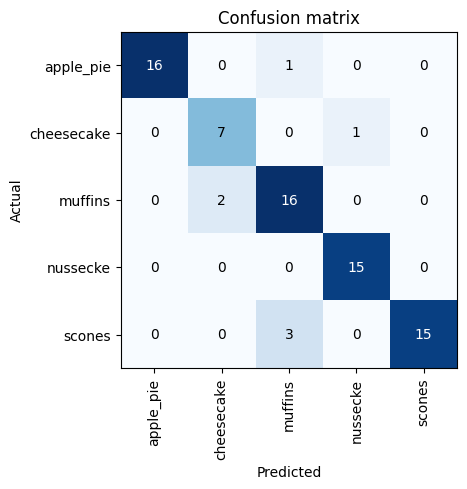

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

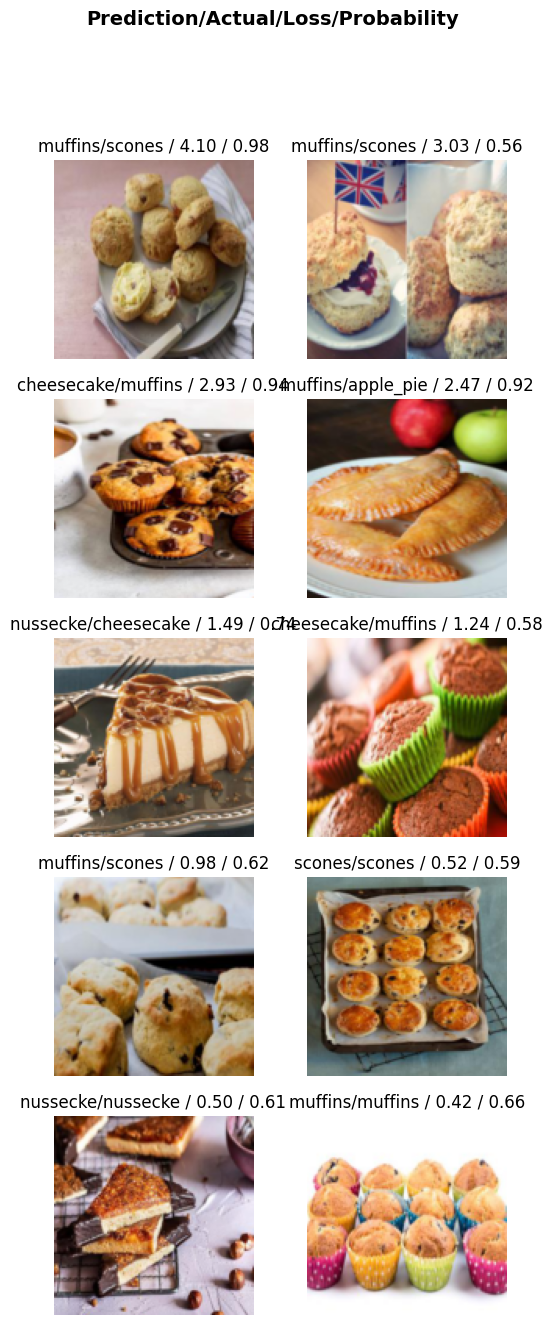

In [11]:
interp.plot_top_losses(10, nrows=5)

## Export the Finetuned Model
The model will be exported as "export.pkl" in the same folder as this notebook

In [12]:
learn.export()